In [1]:
%cd /content/drive/MyDrive/compvis/Car_Measure/
!pwd 

/content/drive/MyDrive/compvis/Car_Measure
/content/drive/MyDrive/compvis/Car_Measure


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image


class Dataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(root+'/car-segmentation/images/')))

    def __getitem__(self, idx):

        img_name = self.imgs[idx].replace('.png','')
        img = Image.open(self.root+'/car-segmentation/images/'+self.imgs[idx]).convert("RGB")

        mask_1 = Image.open(self.root+'/car-segmentation/new_masks/'+img_name+'_mask_1.png').convert('P')
        mask_1 = np.array(mask_1)

        mask_2 = Image.open(self.root+'/car-segmentation/new_masks/'+img_name+'_mask_2.png').convert('P')
        mask_2 = np.array(mask_2)

        obj_ids_1 = np.unique(mask_1)
        obj_ids_1 = obj_ids_1[1:]
        labels = [1] * len(obj_ids_1)

        masks = []
        masks_1 = mask_1 == obj_ids_1[:, None, None]
        for ii in masks_1:
          ii = ii.astype(int)
          masks.append(ii)


        obj_ids_2 = np.unique(mask_2)
        obj_ids_2 = obj_ids_2[1:]
        labels_2 = [2] * len(obj_ids_2)

        masks_2 = mask_2 == obj_ids_2[:, None, None]

        masks_2b = []
        for ii in masks_2:
          ii = ii.astype(int)
          ii = np.where(ii > 1, 1, ii)
          masks_2b.append(ii)

        labels = labels + labels_2
        masks = masks + masks_2b

        num_objs = len(masks)

        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            if xmin == xmax: #To fix boxes that caused errors, probably better solution
              xmax = xmax + 1
            if ymin == ymax:
              ymax = ymax + 1
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])

        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [ ]:
imgs = list(sorted(os.listdir('./car-segmentation/images/')))

img_name = imgs[0].replace('.png','')
#print(img_name)
img = Image.open('./car-segmentation/images/'+imgs[0]).convert("RGB")

mask_1 = Image.open('./car-segmentation/new_masks/'+img_name+'_mask_1.png').convert('P')
mask_1 = np.array(mask_1)

mask_2 = Image.open('./car-segmentation/new_masks/'+img_name+'_mask_2.png').convert('P')
mask_2 = np.array(mask_2)

obj_ids_1 = np.unique(mask_1)
obj_ids_1 = obj_ids_1[1:]
labels = [1] * len(obj_ids_1)

masks = []
masks_1 = mask_1 == obj_ids_1[:, None, None]
for ii in masks_1:
  ii = ii.astype(int)
  masks.append(ii)


obj_ids_2 = np.unique(mask_2)
obj_ids_2 = obj_ids_2[1:]
labels_2 = [2] * len(obj_ids_2)

masks_2 = mask_2 == obj_ids_2[:, None, None]

masks_2b = []
for ii in masks_2:
  ii = ii.astype(int)
  ii = np.where(ii == 1, 2, ii)
  ii = np.where(ii > 2, 2, ii)
  masks_2b.append(ii)

labels = labels + labels_2
masks = masks + masks_2b

num_objs = len(masks)

boxes = []
for i in range(num_objs):
    pos = np.where(masks[i])
    xmin = np.min(pos[1])
    xmax = np.max(pos[1])
    ymin = np.min(pos[0])
    ymax = np.max(pos[0])
    if xmin == xmax: #To fix boxes that caused errors, probably better solution
      xmax = xmax + 1
    if ymin == ymax:
      ymax = ymax + 1

    # assert xmin >= 0
    # assert xmax <= width
    # assert xmin <= xmax

    # assert ymin >= 0
    # assert ymax <= height
    # assert ymin <= ymax
    boxes.append([xmin, ymin, xmax, ymax])

boxes = torch.as_tensor(boxes, dtype=torch.float32)

labels = torch.as_tensor(labels, dtype=torch.int64)
masks = torch.as_tensor(masks, dtype=torch.uint8)

image_id = torch.tensor([0])

area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

target = {}
target["boxes"] = boxes
target["labels"] = labels
target["masks"] = masks
target["image_id"] = image_id
target["area"] = area
target["iscrowd"] = iscrowd

print(target)

{'boxes': tensor([[ 59.,  25., 831., 342.],
        [137., 213., 280., 344.],
        [635., 213., 770., 345.]]), 'labels': tensor([1, 2, 2]), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8), 'image_id': tensor([0]), 'area': tensor([244724.,  18733.,  17820.]), 'iscrowd': tensor([0, 0, 0])}


In [4]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def build_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features #What does cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # Stop here if you are fine-tunning Faster-RCNN

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels #what does conv5_mask.in_channels mean?
    hidden_layer = 256 #Where does hidden layer come from, how do we know 256, what happens if changed?
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [5]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []

    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())

    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms) #This and T.ToTensor() found in pretrained one

# use our dataset and defined transformations
dataset = Dataset('/content/drive/MyDrive/compvis/Car_Measure', get_transform(train=True))
dataset_test = Dataset('/content/drive/MyDrive/compvis/Car_Measure', get_transform(train=False))

# split the dataset in train and test set, the way its done above could there not be overlap between two, does this matter?
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=2,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=2,
    collate_fn=utils.collate_fn)

In [ ]:
dataset[0]

(tensor([[[0.8588, 0.8745, 0.8706,  ..., 0.4863, 0.3490, 0.2941],
          [0.9137, 0.8667, 0.8902,  ..., 0.3059, 0.5176, 0.7098],
          [0.7843, 0.8941, 0.9059,  ..., 0.9137, 0.9412, 0.9059],
          ...,
          [0.5216, 0.3804, 0.3216,  ..., 0.5098, 0.6588, 0.4784],
          [0.4314, 0.4431, 0.4471,  ..., 0.4863, 0.6078, 0.4902],
          [0.4510, 0.5098, 0.5216,  ..., 0.3882, 0.4275, 0.4314]],
 
         [[0.8392, 0.8549, 0.8510,  ..., 0.5098, 0.3647, 0.3020],
          [0.8941, 0.8471, 0.8706,  ..., 0.3294, 0.5333, 0.7255],
          [0.7725, 0.8824, 0.8941,  ..., 0.9373, 0.9569, 0.9216],
          ...,
          [0.4980, 0.3569, 0.2980,  ..., 0.4902, 0.6392, 0.4588],
          [0.4157, 0.4275, 0.4314,  ..., 0.4667, 0.5882, 0.4706],
          [0.4353, 0.4941, 0.5059,  ..., 0.3686, 0.4078, 0.4118]],
 
         [[0.8157, 0.8314, 0.8275,  ..., 0.5647, 0.4118, 0.3529],
          [0.8706, 0.8235, 0.8471,  ..., 0.3843, 0.5804, 0.7725],
          [0.7451, 0.8549, 0.8667,  ...,

In [6]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has 3 classes - background, car and wheel
num_classes = 3

# get the model using our helper function
model = build_model(num_classes)
# move model to the right device, why is this done?
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

In [ ]:
#Error to do with RGBA here, could be to do with png images

# number of epochs
num_epochs = 5

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [ 0/77]  eta: 0:09:30  lr: 0.000071  loss: 4.5491 (4.5491)  loss_classifier: 1.0331 (1.0331)  loss_box_reg: 0.1799 (0.1799)  loss_mask: 2.9685 (2.9685)  loss_objectness: 0.3111 (0.3111)  loss_rpn_box_reg: 0.0564 (0.0564)  time: 7.4151  data: 5.3841  max mem: 2589
Epoch: [0]  [10/77]  eta: 0:02:43  lr: 0.000728  loss: 2.2469 (2.6957)  loss_classifier: 0.5954 (0.6741)  loss_box_reg: 0.2799 (0.3119)  loss_mask: 1.3345 (1.5698)  loss_objectness: 0.0548 (0.1213)  loss_rpn_box_reg: 0.0135 (0.0186)  time: 2.4356  data: 0.8441  max mem: 3027
Epoch: [0]  [20/77]  eta: 0:02:19  lr: 0.001385  loss: 1.4497 (2.2831)  loss_classifier: 0.3688 (0.5011)  loss_box_reg: 0.4071 (0.3800)  loss_mask: 0.3952 (0.9593)  loss_objectness: 0.0180 (0.2707)  loss_rpn_box_reg: 0.0135 (0.1720)  time: 2.1925  data: 0.5901  max mem: 3027
Epoch: [0]  [30/77]  eta: 0:01:46  lr: 0.002042  loss: 0.8949 (1.8049)  loss_classifier: 0.2092 (0.3963)  loss_box_reg: 0.3890 (0.3702)  loss_mask: 0.1946 (0.7004)  loss_ob

In [ ]:
#torch.save(model, 'mask-rcnn-car-measure.pt')

In [9]:
#model = torch.load('mask-rcnn-car-measure.pt')
model = torch.load('mask-rcnn-car-measure.pt',map_location=torch.device('cpu'))

In [10]:
# set to evaluation mode
model.eval()
CLASS_NAMES = ['__background__', 'car', 'wheel']
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [11]:
%matplotlib inline
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T
import torchvision
import numpy as np

import cv2
import random
import warnings
warnings.filterwarnings('ignore')

def get_coloured_mask(mask):
    """
    random_colour_masks
      parameters:
        - image - predicted masks
      method:
        - the masks of each predicted object is given random colour for visualization
    """
    colours = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],[80, 70, 180],[250, 80, 190],[245, 145, 50],[70, 150, 250],[50, 190, 190]]
    r = np.zeros_like(mask).astype(np.uint8)
    g = np.zeros_like(mask).astype(np.uint8)
    b = np.zeros_like(mask).astype(np.uint8)
    r[mask == 1], g[mask == 1], b[mask == 1] = colours[random.randrange(0,10)]
    coloured_mask = np.stack([r, g, b], axis=2)
    return coloured_mask

def get_prediction(img_path, confidence):

    #Comments on workings of this in pretrained notebook


    """
    get_prediction
      parameters:
        - img_path - path of the input image
        - confidence - threshold to keep the prediction or not
      method:
        - Image is obtained from the image path
        - the image is converted to image tensor using PyTorch's Transforms
        - image is passed through the model to get the predictions
        - masks, classes and bounding boxes are obtained from the model and soft masks are made binary(0 or 1) on masks
          ie: eg. segment of cat is made 1 and rest of the image is made 0
    
    """
    img = Image.open(img_path)
    transform = T.Compose([T.ToTensor()])
    img = transform(img)

    img = img.to(device)
    pred = model([img])
    pred_score = list(pred[0]['scores'].detach().cpu().numpy())
    pred_t = [pred_score.index(x) for x in pred_score if x>confidence][-1]
    masks = (pred[0]['masks']>0.5).squeeze().detach().cpu().numpy()
    # print(pred[0]['labels'].numpy().max())
    pred_class = [CLASS_NAMES[i] for i in list(pred[0]['labels'].cpu().numpy())]
    pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().cpu().numpy())]
    masks = masks[:pred_t+1]
    pred_boxes = pred_boxes[:pred_t+1]
    pred_class = pred_class[:pred_t+1]
    return masks, pred_boxes, pred_class, pred_score

def segment_instance(img_path, confidence=0.5, rect_th=2, text_size=2, text_th=2):
    """
    segment_instance
      parameters:
        - img_path - path to input image
        - confidence- confidence to keep the prediction or not
        - rect_th - rect thickness
        - text_size
        - text_th - text thickness
      method:
        - prediction is obtained by get_prediction
        - each mask is given random color
        - each mask is added to the image in the ration 1:0.8 with opencv
        - final output is displayed
    """
    masks, boxes, pred_cls, pred_scr = get_prediction(img_path, confidence)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    for i in range(len(masks)):
      rgb_mask = get_coloured_mask(masks[i])
      if i == 0:
        rgb_orig = rgb_mask
      if i == 1:
        img_2 = cv2.addWeighted(rgb_mask, 1, rgb_orig, 1, 0)
      if i > 0:
        img_2 = cv2.addWeighted(rgb_mask, 1, img_2, 1, 0)
      img = cv2.addWeighted(img, 1, rgb_mask, 0.5, 0)
      cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th)
      cv2.putText(img,pred_cls[i], boxes[i][0], cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th)
      cv2.putText(img,str(pred_scr[i]), (int(boxes[i][0][0]+20),int(boxes[i][0][1]+30)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0),thickness=text_th)
    plt.figure(figsize=(20,30))
    plt.imshow(img)
    #plt.imshow(img_2)
    plt.xticks([])
    plt.yticks([])
    print(len(masks))
    plt.show()

3


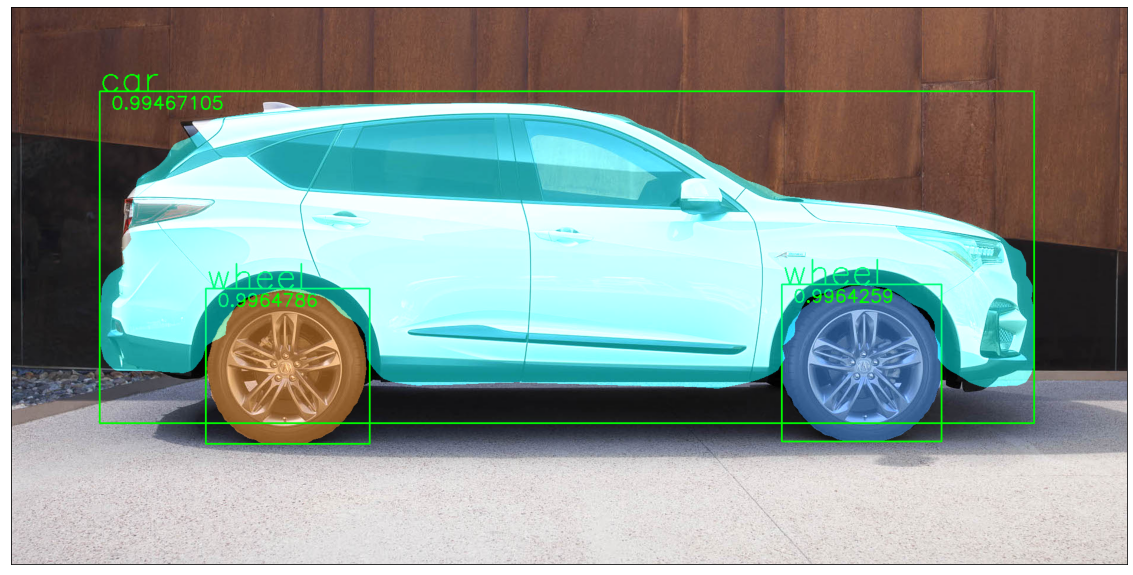

In [12]:
segment_instance('/content/drive/MyDrive/compvis/Car_Measure/2019-acura-rdx-11.jpg', confidence=0.99)

3


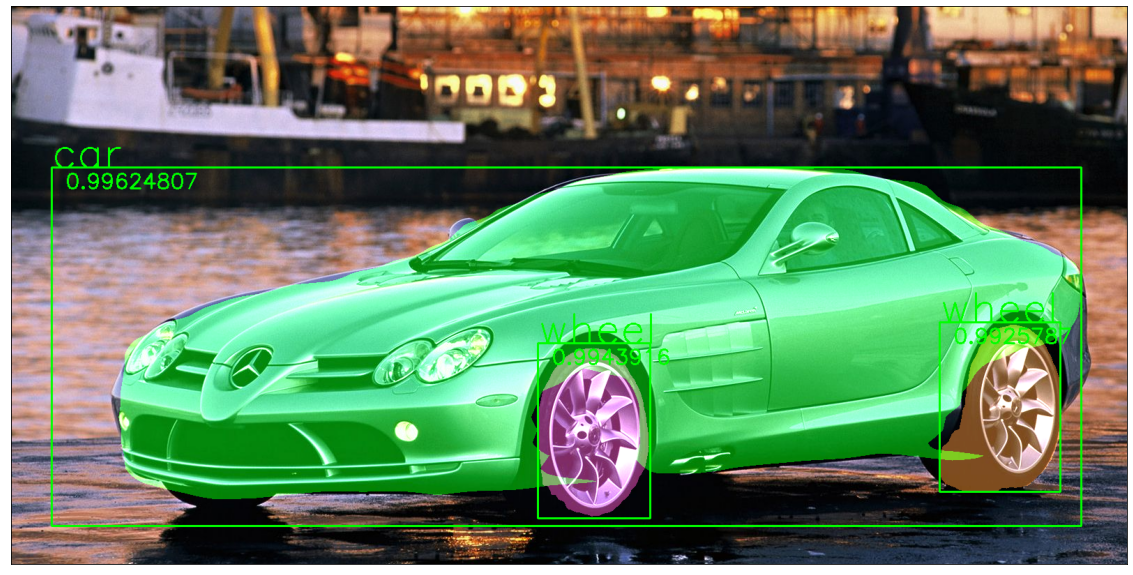

In [14]:
segment_instance('/content/drive/MyDrive/compvis/Car_Measure/mercedes-benz-slr_mclaren_2004_1600x1200_wallpaper_18.jpg', confidence=0.99)